# Dataset 준비

In [1]:
!pip install torchsummary -q

In [2]:
import os
import cv2
import PIL
import numpy as np
from tqdm.notebook import tqdm
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
from torchvision import transforms
import torchsummary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
path = "/kaggle/input/image-localization-dataset/training_images"
count = 0

for file in os.listdir(path):
    if file.endswith(".jpg"):
        image_path = os.path.join(path, file)
        xml_path = os.path.join(path, file.replace(".jpg", ".xml"))
        if os.path.exists(xml_path) and os.path.exists(image_path) and count < 10:
            print(f"image:{image_path}\nxml:{xml_path}\n")
            count += 1

image:/kaggle/input/image-localization-dataset/training_images/eggplant_35.jpg
xml:/kaggle/input/image-localization-dataset/training_images/eggplant_35.xml

image:/kaggle/input/image-localization-dataset/training_images/mushroom_17.jpg
xml:/kaggle/input/image-localization-dataset/training_images/mushroom_17.xml

image:/kaggle/input/image-localization-dataset/training_images/cucumber_57.jpg
xml:/kaggle/input/image-localization-dataset/training_images/cucumber_57.xml

image:/kaggle/input/image-localization-dataset/training_images/cucumber_30.jpg
xml:/kaggle/input/image-localization-dataset/training_images/cucumber_30.xml

image:/kaggle/input/image-localization-dataset/training_images/eggplant_51.jpg
xml:/kaggle/input/image-localization-dataset/training_images/eggplant_51.xml

image:/kaggle/input/image-localization-dataset/training_images/eggplant_10.jpg
xml:/kaggle/input/image-localization-dataset/training_images/eggplant_10.xml

image:/kaggle/input/image-localization-dataset/training_im

## XML 파일 읽기 및 구조

`xml.etree.ElementTree` 모듈을 사용하면 XML 파일에서 원하는 데이터를 쉽게 추출할 수 있습니다.  
  
XML 파일은 객체 탐지를 위한 라벨링 정보를 포함하고 있습니다. 이 파일에서는 이미지의 경로, 크기, 객체의 이름, 그리고 바운딩 박스 정보(객체의 좌표) 등이 담겨 있습니다. 

```xml
<annotation>
	<folder>single cucumber</folder>
	<filename>cucumber_31.jpg</filename>
	<path>C:\Users\Muhammed Buyukkinaci\Downloads\single cucumber\cucumber_31.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>227</width>
		<height>227</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>cucumber</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>36</xmin>
			<ymin>11</ymin>
			<xmax>215</xmax>
			<ymax>207</ymax>
		</bndbox>
	</object>
</annotation>
```


이 중 주목해야 할 주요 요소는 다음과 같습니다.

- `<filename>`: 이미지 파일 이름 (예: cucumber_31.jpg)
- `<size>`: 이미지의 크기 (width, height, depth)
- `<object>`: 탐지할 객체의 정보 (예: cucumber)
- `<bndbox>`: 객체의 좌표 정보 (xmin, ymin, xmax, ymax)

In [4]:
xml_path = "/kaggle/input/image-localization-dataset/training_images/eggplant_35.xml"

# XML 파싱
tree = ET.parse(xml_path)
root = tree.getroot()

In [5]:
# 파일 이름, 경로, 이미지 크기 정보 추출
filename = root.find('filename').text
image_path = root.find('path').text
size = root.find('size')
width = int(size.find('width').text)
height = int(size.find('height').text)

print(f"filename: {filename}\nimage_path: {image_path}\nwidth: {width}\nheight: {height}")

filename: eggplant_35.jpg
image_path: C:\Users\Muhammed Buyukkinaci\Downloads\single eggplant\eggplant_35.jpg
width: 227
height: 227


In [7]:
# 객체 정보 추출
obj = root.find('object')
label = obj.find('name').text
bndbox = obj.find('bndbox')
xmin = int(bndbox.find('xmin').text)
ymin = int(bndbox.find('ymin').text)
xmax = int(bndbox.find('xmax').text)
ymax = int(bndbox.find('ymax').text)

print(f"label: {label}\nxmin: {xmin}\nymin: {ymin}\nxmax: {xmax}\nymax: {ymax}")

label: eggplant
xmin: 28
ymin: 70
xmax: 181
ymax: 177


## 데이터 확인

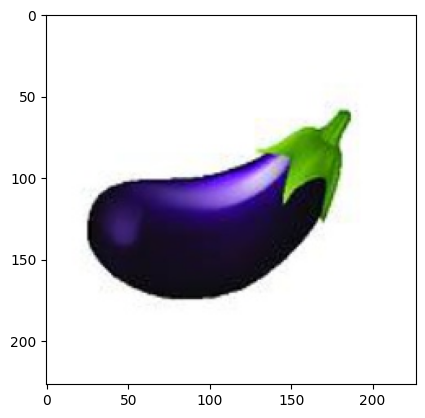

In [8]:
image_path = "/kaggle/input/image-localization-dataset/training_images/eggplant_35.jpg"

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image)
plt.show()

In [9]:
def draw_bbox_cywh_normalized(image_path):
    """
    이미지 경로 입력 시 xml 파일을 불러오고, bbox 정보를 추출하여 이미지+bbox를 그려주는 함수
    """
    # Your code
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    xml_path = image_path.replace('.jpg', '.xml')
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    obj = root.find('object')
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)
    
    top_left = (xmin, ymin)
    bottom_right = (xmax, ymax)
    
    cv2.rectangle(image, top_left, bottom_right, (255, 0, 0), thickness=2)
    
    plt.imshow(image)
    plt.show()

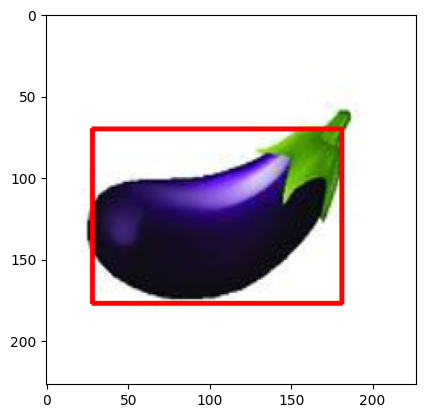

In [10]:
draw_bbox_cywh_normalized("/kaggle/input/image-localization-dataset/training_images/eggplant_35.jpg")

### Scaled Bounding Box로 이미지 그리기

In [11]:
class2label = {"mushroom": 0, "eggplant": 1, "cucumber": 2}
label2class = {v: k for k, v in class2label.items()}

sample_bbox = torch.tensor([xmin, ymin, xmax, ymax]).float() / torch.tensor([width, height, width, height]).float()

sample_label = torch.tensor(class2label[label])

print(f"bbox: {sample_bbox}\nlabel: {sample_label}")

bbox: tensor([0.1233, 0.3084, 0.7974, 0.7797])
label: 1


In [12]:
sample_bbox * torch.tensor([width, height, width, height]).float()

tensor([ 28.,  70., 181., 177.])

In [15]:
def draw_bbox(image, bbox, label):
    """
    이미지 및 바운딩 박스를 그려주는 함수
    """
    # 바운딩 박스 좌표를 이미지 크기에 맞게 스케일링하고 정수형으로 변환
    # Your code
    width, height = image.shape[1], image.shape[0]
    bbox = (bbox * torch.tensor([width, height, width, height]).float()).numpy().astype(int)
    image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    
    # 클래스 라벨을 타이틀로 설정
    plt.title(label2class[int(label)])
    plt.imshow(image)
    plt.show()

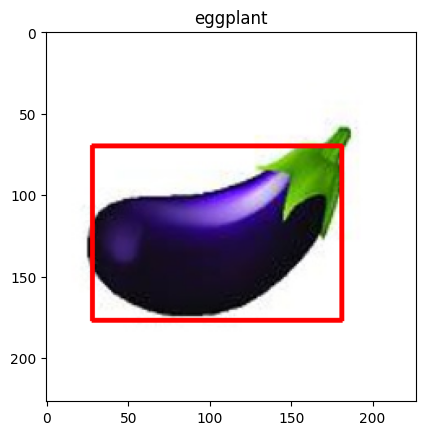

In [16]:
draw_bbox(image, sample_bbox, sample_label)

## Dataset & DataLoader 구성

In [188]:
class customDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.annotation_files = []
        self.classes = {"mushroom": 0, "eggplant": 1, "cucumber": 2}
        
        # 이미지와 XML 파일을 쌍으로 추출하여 정리
        
        for file in os.listdir(self.root_dir):
            if file.endswith(".jpg"):
                image_path = self.root_dir + '/' + file
#                 print(image_path)
                xml_path = self.root_dir + '/' + file.replace(".jpg", ".xml")
#                 print(xml_path)
                self.image_files.append(image_path)
                self.annotation_files.append(xml_path)
                    
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # 이미지 파일과 XML 파일 경로
        image_path = self.image_files[idx]
        xml_path = self.annotation_files[idx]
        
        # 이미지 읽기
        image = PIL.Image.open(image_path)

        # XML 파일에서 바운딩 박스 정보 추출
        tree = ET.parse(xml_path)
        root = tree.getroot()
        
        size = root.find('size')
        width = int(size.find('width').text)
        height = int(size.find('height').text)

        obj = root.find('object')
        bndbox = obj.find('bndbox')
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
        bbox = torch.tensor([xmin, ymin, xmax, ymax]).float() / torch.tensor([width, height, width, height]).float()
        
        # 객체 정보 추출
        label_srt = obj.find('name').text
        label = self.classes[label_srt]
        
        if self.transform:
            image = self.transform(image)

        return image, bbox, label

In [189]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [190]:
dataset = customDataset("/kaggle/input/image-localization-dataset/training_images", transform=transform)
train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [191]:
len(train_dataset), len(val_dataset)

(149, 37)

In [192]:
train_dataset[0]

(tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],
 
         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],
 
         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ...,

# 모델링

In [210]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [211]:
class detector(nn.Module):
    def __init__(self, num_classes):
        super(detector, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.relu = nn.ReLU()
        
        # Fully Connected Layer
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 64)
        
        # Output layers: bbox 예측(xmin, ymin, xmax, ymax) & 분류기
        self.fc_bbox = nn.Linear(64, 4)  # 바운딩 박스 좌표 예측
        self.fc_class = nn.Linear(64, num_classes)  # 클래스 예측
    
    def forward(self, x):
        # Backbone
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten
        x = x.view(-1, 28 * 28 * 64)
        
        # FCL
        x = self.fc1(x)
        x = self.fc2(x)
        
        # Detection Head
        bbox = self.fc_bbox(x)
        class_logits = self.fc_class(x)
        
        return bbox, class_logits

In [212]:
# 모델 초기화
num_classes = 3  # cucumber, eggplant, mushroom 3개의 클래스
model = detector(num_classes=num_classes).to(device)
torchsummary.summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             448
              ReLU-2         [-1, 16, 224, 224]               0
         MaxPool2d-3         [-1, 16, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]           4,640
              ReLU-5         [-1, 32, 112, 112]               0
         MaxPool2d-6           [-1, 32, 56, 56]               0
            Conv2d-7           [-1, 64, 56, 56]          18,496
              ReLU-8           [-1, 64, 56, 56]               0
         MaxPool2d-9           [-1, 64, 28, 28]               0
           Linear-10                  [-1, 128]       6,422,656
           Linear-11                   [-1, 64]           8,256
           Linear-12                    [-1, 4]             260
           Linear-13                    [-1, 3]             195
Total params: 6,454,951
Trainable param

In [213]:
# 손실 함수 설정 (MSE for bbox, CrossEntropy for class)
criterion_bbox = nn.MSELoss()  # 바운딩 박스 좌표 예측을 위한 MSE
criterion_class = nn.CrossEntropyLoss()  # 클래스 분류를 위한 CrossEntropy

# 옵티마이저 설정
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [214]:
def train_model(model, train_loader, val_loader, num_epochs, criterion_bbox, criterion_class, optimizer, device):
    model.to(device)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_bbox_loss = 0.0
        running_class_loss = 0.0
        
        # Train
        for images, bboxes, labels in tqdm(train_loader):
            
            images = images.to(device)
            bboxes = bboxes.to(device)
            labels = labels.to(device)
            
            y_pred_bbox, y_pred_class = model(images)
            
            loss_bbox = criterion_bbox(y_pred_bbox, bboxes)
            loss_class = criterion_class(y_pred_class, labels)
            
            w1 = loss_bbox / (loss_bbox + loss_class)
            w2 = loss_class / (loss_bbox + loss_class)
            loss_total = ((loss_bbox * w1) + (loss_class * w2)) / (w1 + w2)
            
            optimizer.zero_grad()
            loss_total.backward()
            optimizer.step()
            
            # 배치의 손실 누적
            running_loss += loss_total.item()
            running_bbox_loss += loss_bbox.item()
            running_class_loss += loss_class.item()
        
        # 에포크 당 훈련 손실 계산
        epoch_loss = running_loss / len(train_loader)
        epoch_bbox_loss = running_bbox_loss / len(train_loader)
        epoch_class_loss = running_class_loss / len(train_loader)
        
        train_losses.append(epoch_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train bbox Loss: {epoch_bbox_loss:.4f}, Train class Loss: {epoch_class_loss:.4f}\nTrain Toal Loss: {epoch_loss:.4f}")
        
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_running_bbox_loss = 0.0
        val_running_class_loss = 0.0
        
        with torch.no_grad():
            for images, bboxes, labels in val_loader:
                
                images = images.to(device)
                bboxes = bboxes.to(device)
                labels = labels.to(device)

                y_pred_bbox, y_pred_class = model(images)

                loss_bbox = criterion_bbox(y_pred_bbox, bboxes)
                loss_class = criterion_class(y_pred_class, labels)
                
                w1 = loss_bbox / (loss_bbox + loss_class)
                w2 = loss_class / (loss_bbox + loss_class)
                loss_total = ((loss_bbox * w1) + (loss_class * w2)) / (w1 + w2)
                
                val_running_loss += loss_total.item()
                val_running_bbox_loss += loss_bbox.item()
                val_running_class_loss += loss_class.item()
        
        # 에포크 당 검증 손실 계산
        val_loss = val_running_loss / len(val_loader)
        val_bbox_loss = val_running_bbox_loss / len(val_loader)
        val_class_loss = val_running_class_loss / len(val_loader)

        val_losses.append(val_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}], Val bbox Loss: {val_bbox_loss:.4f}, Val class Loss: {val_class_loss:.4f}\nVal Total Loss: {val_loss:.4f}")
#     print(train_losses, val_losses)
    return train_losses, val_losses

In [215]:
epochs = 30
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs, criterion_bbox, criterion_class, optimizer, device)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/30], Train bbox Loss: 18.4409, Train class Loss: 13.6609
Train Toal Loss: 19.4204
Epoch [1/30], Val bbox Loss: 0.3148, Val class Loss: 1.0991
Val Total Loss: 0.9246


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [2/30], Train bbox Loss: 0.3827, Train class Loss: 1.0978
Train Toal Loss: 0.9144
Epoch [2/30], Val bbox Loss: 0.4150, Val class Loss: 1.0796
Val Total Loss: 0.8951


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [3/30], Train bbox Loss: 0.7037, Train class Loss: 0.9713
Train Toal Loss: 0.9264
Epoch [3/30], Val bbox Loss: 0.4123, Val class Loss: 0.8427
Val Total Loss: 0.7017


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [4/30], Train bbox Loss: 0.4768, Train class Loss: 0.9977
Train Toal Loss: 0.8345
Epoch [4/30], Val bbox Loss: 0.4217, Val class Loss: 1.0884
Val Total Loss: 0.9023


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [5/30], Train bbox Loss: 0.4555, Train class Loss: 1.0732
Train Toal Loss: 0.8919
Epoch [5/30], Val bbox Loss: 3.6424, Val class Loss: 0.9169
Val Total Loss: 3.0995


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [6/30], Train bbox Loss: 0.9054, Train class Loss: 1.0700
Train Toal Loss: 1.2235
Epoch [6/30], Val bbox Loss: 0.3791, Val class Loss: 1.0996
Val Total Loss: 0.9149


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [7/30], Train bbox Loss: 0.3744, Train class Loss: 1.0991
Train Toal Loss: 0.9151
Epoch [7/30], Val bbox Loss: 0.3680, Val class Loss: 1.0994
Val Total Loss: 0.9160


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [8/30], Train bbox Loss: 0.3700, Train class Loss: 1.0984
Train Toal Loss: 0.9149
Epoch [8/30], Val bbox Loss: 0.3733, Val class Loss: 1.0992
Val Total Loss: 0.9152


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [9/30], Train bbox Loss: 0.3800, Train class Loss: 1.0983
Train Toal Loss: 0.9139
Epoch [9/30], Val bbox Loss: 0.3891, Val class Loss: 1.0990
Val Total Loss: 0.9134


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [10/30], Train bbox Loss: 0.3963, Train class Loss: 1.0984
Train Toal Loss: 0.9123
Epoch [10/30], Val bbox Loss: 0.4090, Val class Loss: 1.0988
Val Total Loss: 0.9117


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [11/30], Train bbox Loss: 0.4175, Train class Loss: 1.0980
Train Toal Loss: 0.9106
Epoch [11/30], Val bbox Loss: 0.4300, Val class Loss: 1.0987
Val Total Loss: 0.9106


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [12/30], Train bbox Loss: 0.4368, Train class Loss: 1.0976
Train Toal Loss: 0.9096
Epoch [12/30], Val bbox Loss: 0.4479, Val class Loss: 1.0986
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [13/30], Train bbox Loss: 0.4546, Train class Loss: 1.0981
Train Toal Loss: 0.9098
Epoch [13/30], Val bbox Loss: 0.4608, Val class Loss: 1.0986
Val Total Loss: 0.9101


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [14/30], Train bbox Loss: 0.4641, Train class Loss: 1.0969
Train Toal Loss: 0.9088
Epoch [14/30], Val bbox Loss: 0.4668, Val class Loss: 1.0985
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [15/30], Train bbox Loss: 0.4676, Train class Loss: 1.0995
Train Toal Loss: 0.9110
Epoch [15/30], Val bbox Loss: 0.4679, Val class Loss: 1.0986
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [16/30], Train bbox Loss: 0.4676, Train class Loss: 1.0975
Train Toal Loss: 0.9093
Epoch [16/30], Val bbox Loss: 0.4651, Val class Loss: 1.0985
Val Total Loss: 0.9101


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [17/30], Train bbox Loss: 0.4631, Train class Loss: 1.0976
Train Toal Loss: 0.9094
Epoch [17/30], Val bbox Loss: 0.4613, Val class Loss: 1.0985
Val Total Loss: 0.9101


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [18/30], Train bbox Loss: 0.4574, Train class Loss: 1.0978
Train Toal Loss: 0.9097
Epoch [18/30], Val bbox Loss: 0.4559, Val class Loss: 1.0985
Val Total Loss: 0.9101


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [19/30], Train bbox Loss: 0.4540, Train class Loss: 1.0994
Train Toal Loss: 0.9109
Epoch [19/30], Val bbox Loss: 0.4524, Val class Loss: 1.0986
Val Total Loss: 0.9101


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [20/30], Train bbox Loss: 0.4513, Train class Loss: 1.0971
Train Toal Loss: 0.9089
Epoch [20/30], Val bbox Loss: 0.4513, Val class Loss: 1.0986
Val Total Loss: 0.9101


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [21/30], Train bbox Loss: 0.4507, Train class Loss: 1.0977
Train Toal Loss: 0.9095
Epoch [21/30], Val bbox Loss: 0.4519, Val class Loss: 1.0986
Val Total Loss: 0.9101


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [22/30], Train bbox Loss: 0.4533, Train class Loss: 1.0974
Train Toal Loss: 0.9092
Epoch [22/30], Val bbox Loss: 0.4527, Val class Loss: 1.0986
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [23/30], Train bbox Loss: 0.4528, Train class Loss: 1.0976
Train Toal Loss: 0.9093
Epoch [23/30], Val bbox Loss: 0.4530, Val class Loss: 1.0987
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [24/30], Train bbox Loss: 0.4542, Train class Loss: 1.0981
Train Toal Loss: 0.9098
Epoch [24/30], Val bbox Loss: 0.4546, Val class Loss: 1.0987
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [25/30], Train bbox Loss: 0.4543, Train class Loss: 1.0978
Train Toal Loss: 0.9096
Epoch [25/30], Val bbox Loss: 0.4548, Val class Loss: 1.0986
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [26/30], Train bbox Loss: 0.4552, Train class Loss: 1.0983
Train Toal Loss: 0.9099
Epoch [26/30], Val bbox Loss: 0.4547, Val class Loss: 1.0987
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [27/30], Train bbox Loss: 0.4551, Train class Loss: 1.0978
Train Toal Loss: 0.9095
Epoch [27/30], Val bbox Loss: 0.4545, Val class Loss: 1.0987
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [28/30], Train bbox Loss: 0.4552, Train class Loss: 1.0973
Train Toal Loss: 0.9091
Epoch [28/30], Val bbox Loss: 0.4557, Val class Loss: 1.0987
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [29/30], Train bbox Loss: 0.4552, Train class Loss: 1.0969
Train Toal Loss: 0.9088
Epoch [29/30], Val bbox Loss: 0.4562, Val class Loss: 1.0986
Val Total Loss: 0.9102


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [30/30], Train bbox Loss: 0.4552, Train class Loss: 1.0980
Train Toal Loss: 0.9096
Epoch [30/30], Val bbox Loss: 0.4547, Val class Loss: 1.0987
Val Total Loss: 0.9102


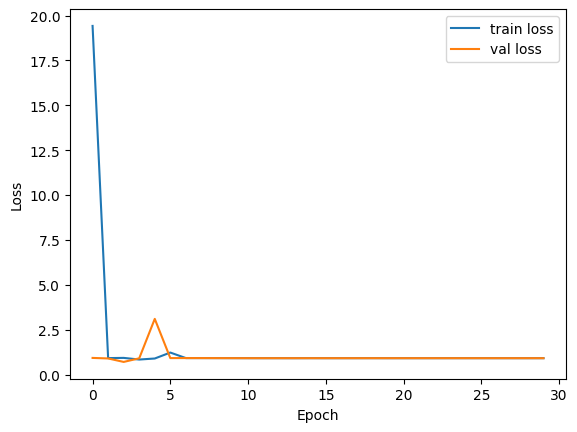

In [216]:
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0, 1])
plt.legend()
plt.show()

In [217]:
def predict(model, image):
    model.eval()
    image = image.to(device)
    output = model(image.unsqueeze(0))
    print(output)
    bbox = output[0][0].detach().cpu()
    class_logits = output[1][0].detach().cpu()
    class_prob = F.softmax(class_logits, dim=-1)
    return bbox, class_prob

In [218]:
bbox, class_prob = predict(model, val_dataset[0][0])
bbox, class_prob

(tensor([[-0.0522, -0.2242, -0.0303, -0.0653]], device='cuda:0',
       grad_fn=<AddmmBackward0>), tensor([[-0.0067, -0.0767,  0.0360]], device='cuda:0',
       grad_fn=<AddmmBackward0>))


(tensor([-0.0522, -0.2242, -0.0303, -0.0653]),
 tensor([0.3360, 0.3133, 0.3507]))

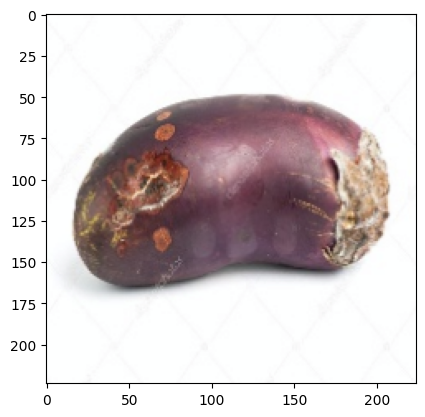

In [219]:
xx = val_dataset[0][0].detach().cpu().numpy().transpose(1, 2, 0)
# denormalize
xx = ((xx * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))*255).astype(np.uint8)

plt.imshow(xx)
plt.show()

In [220]:
def draw_prediction(image, bbox, class_prob):
    image = image.detach().cpu().numpy().transpose(1, 2, 0)
    image = ((image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]))*255).astype(np.uint8)

    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    class_prob = class_prob.argmax(axis=-1)
    print(bbox, class_prob)
    predicted_img = draw_bbox(image, bbox, class_prob)
    return predicted_img

tensor([-0.0522, -0.2242, -0.0303, -0.0653]) tensor(2)


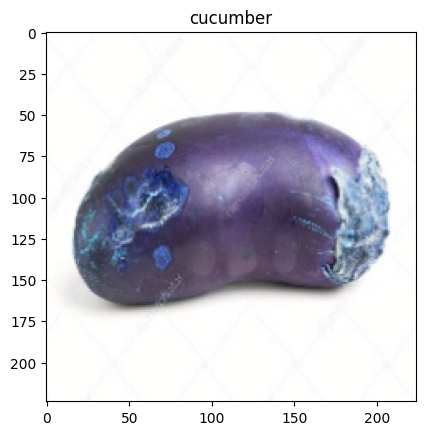

In [221]:
draw_prediction(val_dataset[0][0], bbox, class_prob)